In [1]:
pip install ucimlrepo


In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
census_income = fetch_ucirepo(id=20)

# data (as pandas dataframes)
X = census_income.data.features
y = census_income.data.targets

# metadata
print(census_income.metadata)

# variable information
print(census_income.variables)


{'uci_id': 20, 'name': 'Census Income', 'repository_url': 'https://archive.ics.uci.edu/dataset/20/census+income', 'data_url': 'https://archive.ics.uci.edu/static/public/20/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data.  Also known as Adult dataset.', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5GP7S', 'creators': ['Ron Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && 

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
def preprocess_data(data, categorical_columns, numerical_columns):
    # Separate categorical and numerical columns
    X_cat = data[categorical_columns]
    X_num = data[numerical_columns]

    # One-hot encode categorical columns
    cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    X_cat = cat_encoder.fit_transform(X_cat)

    # Standardize numerical columns
    num_scaler = StandardScaler()
    X_num = num_scaler.fit_transform(X_num)

    return X_num, X_cat, cat_encoder, num_scaler


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda")
class Attention(nn.Module):
    def __init__(self, attention_hidden_size):
        super().__init__()
        self.linear = nn.Linear(attention_hidden_size, attention_hidden_size).to(device)

    def forward(self, encoder_outputs):
      # Transform x using a linear layer; output shape will be (sq, b, hidden_size)
      x_transformed = self.linear(encoder_outputs)
      # Step 2: Compute attention scores using softmax across the sequence dimension (sq)
      # Attention scores shape: (sq, b, hidden_size) -> (b, sq, hidden_size) for softmax
      x_transposed = x_transformed.transpose(0, 1)  # Transposing for softmax operation
      attention_scores = F.softmax(x_transposed, dim=1)  # Applying softmax; shape remains (b, sq, hidden_size)
      # Step 3: Apply attention scores to the original input tensor
      # For weighted sum, first transpose x back: (sq, b, hidden_size) -> (b, sq, hidden_size)
      x = encoder_outputs.transpose(0, 1)  # Transposing x to match attention_scores shape
      # Compute the context vector as the weighted sum of the input vectors
      # (b, sq, hidden_size) * (b, sq, hidden_size) -> (b, hidden_size) after summing over sq dimension
      context_vector = torch.sum(attention_scores * x, dim=1)
      return context_vector





class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        self.linear5 = nn.Linear(hidden_size, hidden_size)
        self.linear6 = nn.Linear(hidden_size, latent_size)
        self.linear_mu = nn.Linear(latent_size, latent_size)
        self.linear_logvar = nn.Linear(latent_size, latent_size)

    def forward(self, x, cat=False):
        out = torch.relu(self.linear1(x))
        out = torch.relu(self.linear2(out))
        out = torch.relu(self.linear3(out))
        out = torch.relu(self.linear4(out))
        out = torch.relu(self.linear5(out))
        out = torch.relu(self.linear6(out))
        mu = self.linear_mu(out)
        logvar = self.linear_logvar(out)

        # Reparameterization trick (as before)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(latent_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

        self.z=None
        self.z1=None
        self.z2=None
        self.z3=None
        self.z4=None
        self.output=None

    def forward(self, z, sig=False):
        #print("decoder 1: ",z.shape)
        #print("decoder 1: ",z)
        self.z=z
        out = torch.relu(self.linear1(z))
        self.z1=out
        out = torch.relu(self.linear2(out))
        self.z2=out
        out = torch.relu(self.linear3(out))
        self.z3=out
        out = torch.relu(self.linear4(out))
        self.z4=out
        out = self.output_layer(out)
        if sig:
          self.output = torch.sigmoid(out)
          return self.output
        else:
          return out
    def backpropagate(self, error_matrix):
      output_layer_copy = nn.Linear(self.output_layer.in_features, self.output_layer.out_features).to(device)  # Create a new Linear layer
      output_layer_copy.weight.data.copy_(self.output_layer.weight.data.clone().detach())  # Copy weights
      output_layer_copy.bias.data.copy_(self.output_layer.bias.data.clone().detach())  # Copy bias
      delta = error_matrix * (self.output.clone().detach() * (1 - self.output.clone().detach()))  # Apply sigmoid derivative
      delta = torch.mm(delta, output_layer_copy.weight)  # Backpropagate through output layer
      # Backpropagate through hidden layers
      linear4_copy = nn.Linear(self.linear4.in_features, self.linear4.out_features).to(device)   # Create a new Linear layer
      linear4_copy.weight.data.copy_(self.linear4.weight.data.clone().detach())  # Copy weights
      linear4_copy.bias.data.copy_(self.linear4.bias.data.clone().detach())  # Copy bias
      linear3_copy = nn.Linear(self.linear3.in_features, self.linear3.out_features).to(device)   # Create a new Linear layer
      linear3_copy.weight.data.copy_(self.linear3.weight.data.clone().detach())  # Copy weights
      linear3_copy.bias.data.copy_(self.linear3.bias.data.clone().detach())  # Copy bias
      linear2_copy = nn.Linear(self.linear2.in_features, self.linear2.out_features).to(device)   # Create a new Linear layer
      linear2_copy.weight.data.copy_(self.linear2.weight.data.clone().detach())  # Copy weights
      linear2_copy.bias.data.copy_(self.linear2.bias.data.clone().detach())  # Copy bias
      linear1_copy = nn.Linear(self.linear1.in_features, self.linear1.out_features).to(device)   # Create a new Linear layer
      linear1_copy.weight.data.copy_(self.linear1.weight.data.clone().detach())  # Copy weights
      linear1_copy.bias.data.copy_(self.linear1.bias.data.clone().detach())  # Copy bias
      delta = torch.mm(delta, linear4_copy.weight)
      delta = delta * torch.relu(linear3_copy(self.z2.clone().detach())) # Derivative of ReLU

      delta = torch.mm(delta, linear3_copy.weight)
      delta = delta * torch.relu(linear2_copy(self.z1.clone().detach())) # Derivative of ReLU

      delta = torch.mm(delta, linear2_copy.weight)
      delta = delta * torch.relu(linear1_copy(self.z.clone().detach())) # Derivative of ReLU

      # linear 1 backpropagation
      delta = torch.mm(delta, linear1_copy.weight)

      return delta  # Return error for the previous layer


import torch
import torch.nn as nn
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, cat=False):
        super().__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size).to(device)
        self.decoder = Decoder(latent_size, hidden_size, input_size).to(device)
        self.cat=cat

    def forward(self, x):
        if self.cat:
          z, logits = self.encoder(x,True)
          recon = self.decoder(z,True)
          return recon, logits
        else:
          z, mu, logvar = self.encoder(x)
          recon = self.decoder(z)
          return recon, mu, logvar



class Generator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.linear0 = nn.Linear(input_size, hidden_size)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.bn = ConditionalBatchNorm1d(hidden_size, input_size)
        self.attention = Attention(input_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        self.linear5 = nn.Linear(hidden_size, hidden_size)
        self.linear11 = nn.Linear(hidden_size, input_size)  # Changed output size

    def forward(self, decoded_z, noise):
        attention_output = self.attention(decoded_z)
        out = torch.relu(self.bn_text(noise, attention_output))
        out = torch.relu(self.linear0(out))
        out = torch.relu(self.linear1(out))
        out = torch.relu(self.linear2(out))
        out = torch.relu(self.linear3(out))
        out = torch.relu(self.linear4(out))
        out = torch.relu(self.linear5(out))
        fake_kg_z = self.linear11(out)  # No more batch norm here
        return fake_kg_z



class ConditionalBatchNorm1d(nn.Module):
    def __init__(self, num_features, num_conditions):
        super().__init__()
        self.num_features = num_features

        # Learnable scale and bias parameters, conditioned on the input 'condition'
        self.gamma_layer = nn.Linear(num_conditions, num_features)
        self.beta_layer = nn.Linear(num_conditions, num_features)

    def forward(self, input, condition):
        #print("input: ",input)
        #print("condition: ",condition)
        out = F.batch_norm(input, None, None, training=True).to(device)  # Standard batch normalization
        #print("out: ",out.shape)
        gamma = self.gamma_layer(condition).to(device)
        beta = self.beta_layer(condition).to(device)

        # Apply scaling and shifting
        out = gamma * out + beta

        return out


class Discriminator(nn.Module):
    def __init__(self, kg_latent_size):
        super().__init__()
        self.linear1 = nn.Linear(kg_latent_size, 128)
        self.linear2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, z):
        out = torch.relu(self.linear1(z))
        out = torch.relu(self.linear2(out))
        out = self.output_layer(out)
        return out  # Output for classification (real or fake)



class RBM(nn.Module):
    def __init__(self, num_visible, num_hidden):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden

        self.W = torch.randn(num_hidden, num_visible).to(device)
        self.h_bias = torch.zeros(num_hidden).to(device)
        self.v_bias = torch.zeros(num_visible).to(device)
        self.input = None
        self.h_probs = None
        self.h_states = None


    def sample_h(self, v):
        v=v.detach()
        p_h = torch.sigmoid(torch.mm(v, self.W.t()) + self.h_bias)  # Calculate hidden unit probabilities
        return p_h, torch.bernoulli(p_h)  # Sample hidden states based on probabilities

    def sample_v(self, h):
        h=h.detach()
        p_v = torch.sigmoid(torch.mm(h, self.W) + self.v_bias)  # Calculate visible unit probabilities
        return p_v, torch.bernoulli(p_v)  # Sample visible states based on probabilities


    def wake_update(self, data):
      # Positive phase
      h_probs, h_states = self.sample_h(data)
      v_probs_pos, v_states_pos = self.sample_v(h_states)

      learning_rate = 0.001
      # True CD
      positive_grad = torch.einsum('bj,bi->ij', data, h_probs)  # Order of 'b' indices swapped
      self.W += learning_rate * positive_grad
      self.v_bias += learning_rate * torch.mean(data - v_probs_pos, dim=0)
      self.h_bias += learning_rate * torch.mean(h_states - h_probs, dim=0)

    def sleep_update(self, data, max_gibbs_steps=10, persistent=True):
        # Negative phase - Gibbs Sampling
        if persistent:
            if not hasattr(self, 'v_state'):  # Initialize if needed
                self.v_state = torch.randn(batch_size, self.num_visible).to(device)
            v_state = self.v_state
        else:
            v_state = data.clone().detach()
        convergence_threshold = 0.0001
        for step in range(max_gibbs_steps):
          h_probs, h_state = self.sample_h(v_state.detach())
          v_probs, v_state = self.sample_v(h_state.detach())

          # Check for convergence (e.g., small change in reconstructed distribution)
          if step > 10:  # Allow for some initial burn-in
            delta = torch.abs(v_probs - v_probs_prev).max()
            if delta < convergence_threshold:
                #print("converged in ",step)
                break  # Exit the loop if converged

          v_probs_prev = v_probs  # Store for convergence check

        # Negative phase
        h_probs_neg, h_states_neg = self.sample_h(v_state.detach())
        v_probs_neg, v_state_neg = self.sample_v(h_states_neg.detach())
        learning_rate = 0.001
        negative_grad = torch.einsum('bi,bj->ij', h_probs_neg, v_state_neg)  # Outer product
        self.W -= learning_rate * negative_grad
        self.v_bias -= learning_rate * torch.mean(v_state_neg - v_probs_neg, dim=0)
        self.h_bias -= learning_rate * torch.mean(h_states_neg - h_probs_neg, dim=0)

        if persistent:  # Update the persistent state
          self.v_state = v_state
    def forward(self, x):
        h_probs, h_states = self.sample_h(x.to(device))

        # Store relevant values
        self.h_probs = h_probs
        self.h_states = h_states
        self.input = x
        return h_probs, h_states  # Or return both h_states and v_states

    def backpropagate(self, delta):
      # 1. Calculate gradient of the output with respect to hidden pre-activations
      grad_h_preact = delta * self.h_probs.detach() * (1 - self.h_probs.detach())

      # 2. Calculate gradient of weights
      grad_W = torch.mm(grad_h_preact.t(), self.input.detach())

      # 3. Calculate gradient of hidden bias
      grad_h_bias = grad_h_preact.sum(dim=0)

      # 4. Propagate gradient to the previous layer
      prev_delta = torch.mm(grad_h_preact, self.W.detach())
      learning_rate = 0.00001
      self.W -=  learning_rate * grad_W
      self.h_bias -= learning_rate * grad_h_bias

      return prev_delta




class DBN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.rbm_layers = nn.ModuleList()
        for i in range(len(hidden_sizes) - 1):
            self.rbm_layers.append(RBM(hidden_sizes[i], hidden_sizes[i + 1]))
        for rbm_layer in self.rbm_layers:
          for param in rbm_layer.parameters():
            param.requires_grad = False
            param.detach_()
        # Top layer can be a normal classifier
        self.output_layer = Decoder(hidden_sizes[-1],128, output_size)

    def forward(self, x):
        for rbm in self.rbm_layers:
            x, _ = rbm(x)
           # print("x: ",x)
        return self.output_layer(x,True)
    def train_wake_sleep(self, data_loader, epochs, persistent=True):
        for epoch in range(epochs):
            print("epoch: ",epoch)
            rbm_id=0
            for rbm in self.rbm_layers:
              i=0
              print("layer: ",rbm.num_hidden)
              for _, data in data_loader:
                if len(data)!=batch_size:
                  continue
                for prev_rbm in self.rbm_layers[:rbm_id]:  # Iterate up to, but not including, the current rbm
                    data, _ = prev_rbm(data)
                i+=1
                for inner_epoch in range(10000000):
                  previous_weights = rbm.W.clone()
                  rbm.wake_update(data.to(device))
                  rbm.sleep_update(data.to(device), 1000, persistent)
                  delta = torch.abs(rbm.W - previous_weights).mean()
                  #print("inner epoch: ",inner_epoch, " delta: ",delta)
                  if inner_epoch % 1000 == 0 and inner_epoch!=0:
                    print("inner epoch: ",inner_epoch," delta: ",delta)
                  if delta < 0.0001:
                    if inner_epoch>=50:
                      print("data ",i," converged in ",inner_epoch," epochs")
                    break  # Break out of the inner training loop
              rbm_id+=1
    def manual_backpropagation(self, loss):
        loss=loss.clone().detach()
        # 1. Backpropagate through the decoder
        delta = self.output_layer.backpropagate(loss)
       # print("delta 0: ",delta.mean().item())
        # Backpropagate through the RBM layers in reverse order
        for rbm in reversed(self.rbm_layers):
            delta = rbm.backpropagate(delta)
           # print("delta ",rbm.num_hidden,": ",delta.mean().item())





In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Identify categorical and numerical features
categorical_columns = ['workclass', 'education', 'marital-status',
                       'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical_columns = ['age', 'fnlwgt', 'education-num',
                     'capital-gain', 'capital-loss', 'hours-per-week']

# Preprocess the data
X_num, X_cat, cat_encoder, num_scaler = preprocess_data(census_income.data.features, categorical_columns, numerical_columns)
# Define hyperparameters
batch_size = 2048
shuffle = True  # Shuffle data for better training

class CombinedDataset(Dataset):
    def __init__(self, X_num, X_cat):
        self.X_num = torch.from_numpy(X_num).float()
        self.X_cat = torch.from_numpy(X_cat).float()

    def __len__(self):
        return len(self.X_num)  # Assuming both splits have the same number of samples

    def __getitem__(self, index):
        return self.X_num[index], self.X_cat[index]

# Create the Dataset
dataset = CombinedDataset(X_num, X_cat)

# Create the DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=shuffle
)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
import torch.nn.functional as F

torch.autograd.set_detect_anomaly(True)
def train_dbn(dataloader, dbn_model, num_epochs, learning_rate, device):
    dbn_model.to(device)  # Ensure model is on the correct device

    optimizer = torch.optim.Adam(dbn_model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        if epoch < 5:
          dbn_model.train_wake_sleep(dataloader,5,False)
        else:
          dbn_model.train_wake_sleep(dataloader,5)
        # Decoder training
        for v in range(100):
          for _, data in dataloader:  # Assuming your data has targets
            if len(data) != batch_size:
                continue

            data = data.to(device)

            optimizer.zero_grad()   # Clear gradients from previous step

            # Forward pass to get latent representation and reconstruction
            reconstruction = dbn_model(data)  # Pass data through RBMs, get latent representation

            # Calculate loss and backpropagate
            loss = F.binary_cross_entropy(reconstruction, data)
            loss.backward(retain_graph=True)
            if v>50:
              loss = F.binary_cross_entropy(reconstruction, data, reduction='none')
              dbn_model.manual_backpropagation(loss)

            optimizer.step()
        with torch.no_grad():  # Temporarily disable gradient calculations
          dbn_model.eval()  # Set model to evaluation mode
          total_error = 0
          i=0
          for _, data in dataloader:
            if len(data)!=batch_size:
              i+=1
              continue
            data=data.to(device)
            reconstruction = dbn_model(data)
            reconstruction_error = F.binary_cross_entropy(reconstruction, data)  # Example metric
            total_error += reconstruction_error
          print(f"Epoch {epoch}, Reconstruction Error: {total_error/i:.4f}")
          dbn_model.train()  # Switch back to training mode


dbn_model = DBN(input_size=X_cat.shape[1], hidden_sizes=[105,512,128,32], output_size=X_cat.shape[1]).to(device)
train_dbn(dataloader, dbn_model, num_epochs=100000, learning_rate=0.01, device="cuda")


epoch:  0
layer:  512
inner epoch:  1000  delta:  tensor(0.0006, device='cuda:0')
inner epoch:  2000  delta:  tensor(0.0006, device='cuda:0')
inner epoch:  3000  delta:  tensor(0.0005, device='cuda:0')
inner epoch:  4000  delta:  tensor(0.0004, device='cuda:0')
inner epoch:  5000  delta:  tensor(0.0004, device='cuda:0')
inner epoch:  6000  delta:  tensor(0.0003, device='cuda:0')
inner epoch:  7000  delta:  tensor(0.0002, device='cuda:0')
inner epoch:  8000  delta:  tensor(0.0002, device='cuda:0')
inner epoch:  9000  delta:  tensor(0.0002, device='cuda:0')
inner epoch:  10000  delta:  tensor(0.0002, device='cuda:0')
inner epoch:  11000  delta:  tensor(0.0002, device='cuda:0')
inner epoch:  12000  delta:  tensor(0.0002, device='cuda:0')
inner epoch:  13000  delta:  tensor(0.0002, device='cuda:0')
inner epoch:  14000  delta:  tensor(0.0002, device='cuda:0')
inner epoch:  15000  delta:  tensor(0.0002, device='cuda:0')
inner epoch:  16000  delta:  tensor(0.0002, device='cuda:0')
inner epoch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

torch.save(dbn_model.state_dict(), 'dbn_model.pt')
!cp 'dbn_model.pt' /content/drive/MyDrive

Combined VAE representation - VAE encoder for continous variables, other type of encoder for categorical variables, combined into decoder.

Working with this data I see why tabular data is much harder. Training a VAE on this is much more difficult than other times I've done it. Right now I've split the data into 2, categorical and continous but I'm going to have to split them into groupings of dependencies between variables.

OPTICS is clustering between datapoints but we want clustering of dependencies between variables. Even then there will be large groups of disparate variables.

In [ ]:
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import torch

import torch
import torch.nn as nn
import torch.nn.functional as F  # Provides additional layers and functions

import torch
import torch.distributions as dist


def train_vae(num_vae, dataloader, num_epochs, optimizer_num, device):
    num_vae.train()
    # Train Numerical VAE
    for epoch in range(num_epochs):
      num_vae.train()
      total_loss_num = 0
      for batch_num,_ in dataloader:  # Only iterate over numerical data
        batch_num = batch_num.to(device)
        optimizer_num.zero_grad()
        recon_num, mu_num, logvar_num = num_vae(batch_num)
        loss_num = F.mse_loss(recon_num, batch_num) + \
                       -0.5 * torch.sum(1 + logvar_num - mu_num.pow(2) - logvar_num.exp())
        loss_num.backward()
        optimizer_num.step()
        total_loss_num += loss_num.item()
      avg_loss_num = total_loss_num / len(dataloader)
      print(f'Epoch {epoch + 1}: Num. VAE Loss - {avg_loss_num:.4f}')


#--- Using the loop ---

# Instantiate your VAE model
num_vae = VAE(input_size=X_num.shape[1], hidden_size=512, latent_size=16).to(device)

# Optimizers for each VAE
optimizer_num = optim.Adam(num_vae.parameters(), lr=1e-3)

# Train!
train_vae(num_vae, dataloader, num_epochs=200, optimizer_num=optimizer_num, optimizer_cat=optimizer_cat, device=device)


KeyboardInterrupt: 

In [ ]:
from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def run_optics_and_visualize(data):
    # Perform OPTICS clustering using the provided metric
    optics = OPTICS(min_samples=20)
    optics.fit(data)
    # Get cluster labels
    cluster_labels = optics.labels_

    # Get reachability distances (useful for understanding cluster structure)
    reachability_distances = optics.reachability_
    # Create a dictionary for mapping cluster labels to colors
    color_map = plt.cm.get_cmap('tab10', max(cluster_labels) + 1)  # Adjust colormap as needed
    colors = [color_map(label) for label in cluster_labels]

    # Reduce dimensionality to 2D using PCA
    pca = PCA(n_components=2)
    data_reduced = pca.fit_transform(data)


    # Plot the reduced data with cluster labels as colors
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=cluster_labels)
    plt.title('OPTICS Clusters (PCA Visualization)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

    tsne = TSNE(n_components=2)
    data_reduced = tsne.fit_transform(data)

    # Plot the reduced data with cluster labels as colors
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=cluster_labels)
    plt.title('OPTICS Clusters (t-SNE Visualization)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

<ipython-input-111-e166b5fd1c49>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', max(cluster_labels) + 1)  # Adjust colormap as needed


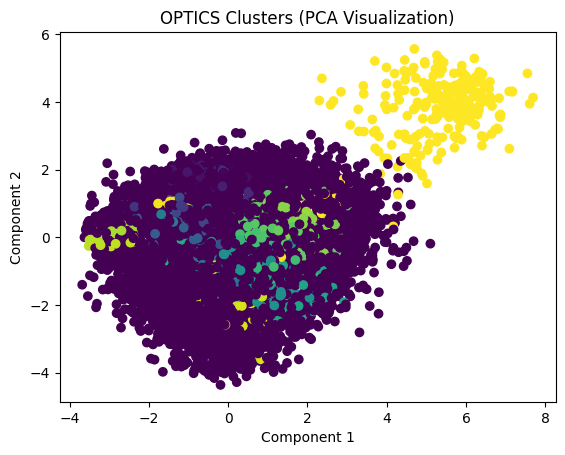

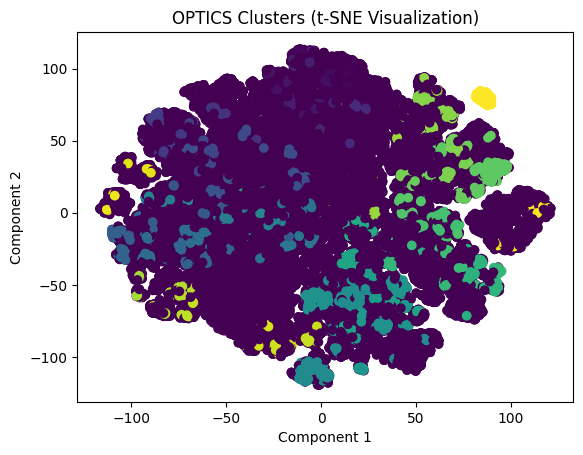

In [ ]:
run_optics_and_visualize(np.concatenate((X_num, X_cat), axis=1))

<ipython-input-111-e166b5fd1c49>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', max(cluster_labels) + 1)  # Adjust colormap as needed


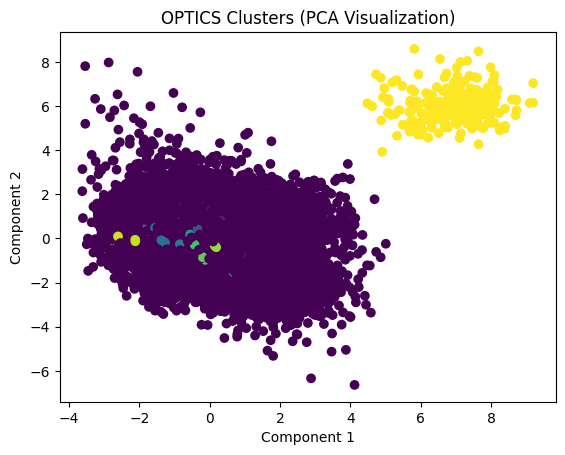

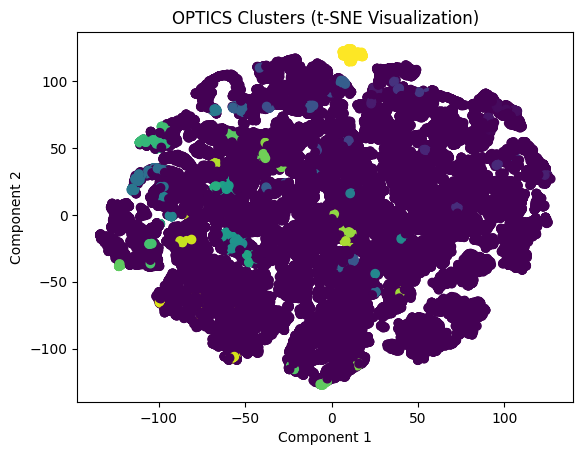

In [ ]:
run_optics_and_visualize(X_num)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
<ipython-input-111-e166b5fd1c49>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', max(cluster_labels) + 1)  # Adjust colormap as needed


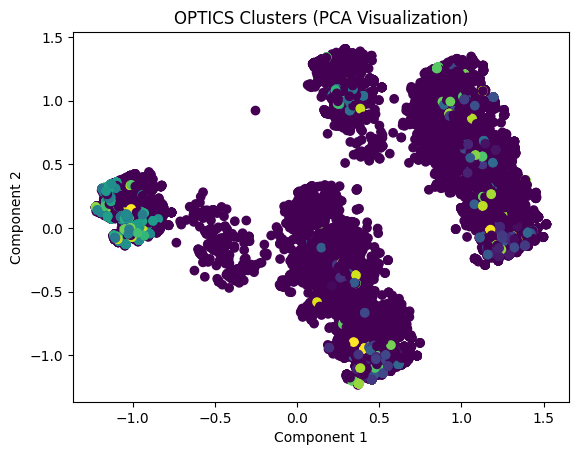

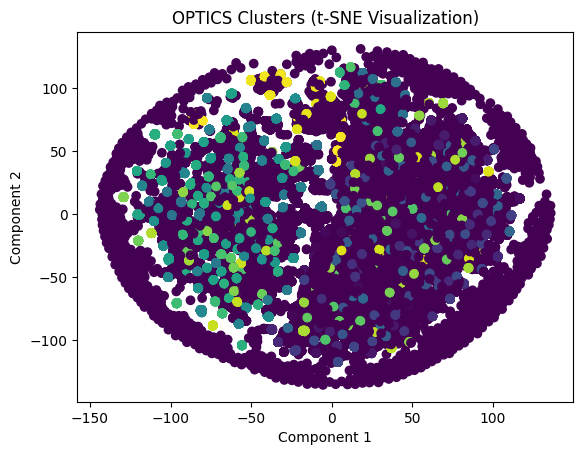

In [ ]:
run_optics_and_visualize(X_cat)